Fabio Ceruti

Fabio Martino

Jacopo Biggiogera

In [1]:
#Iporting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import plotly.express as px
from bs4 import BeautifulSoup
import requests
import statsmodels.formula.api as sm
import scipy.stats as stats
from scipy.stats import kstest
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import yfinance as yp

## Data Exploration

In [2]:
#reading in data
stocks = pd.read_csv('Data_PCLab1_Stock.csv')

#Sort values
stocks= stocks.sort_values(by = 'Date')

#Print number of stocks
print(f'Number of stocks: {len(stocks.columns)-1}')
print('')

#Checking for Null Values
print(f'Are any null values present: {stocks.isnull().values.any()}')
print('')

stocks.head()

Number of stocks: 9

Are any null values present: False



,Date,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
0,2012-01-12,60.198570,75.510002,30.120001,12.13,175.929993,180.550003,28.250000,313.644379,1295.500000
1,2012-01-13,59.972858,74.599998,30.070000,12.35,178.419998,179.160004,22.790001,311.328064,1289.089966
2,2012-01-17,60.671429,75.239998,30.250000,12.25,181.660004,180.000000,26.600000,313.116364,1293.670044
3,2012-01-18,61.301430,75.059998,30.330000,12.73,189.440002,181.070007,26.809999,315.273285,1308.040039
4,2012-01-19,61.107143,75.559998,30.420000,12.80,194.449997,180.520004,26.760000,318.590851,1314.500000


In [3]:
def sprice_plotter(dframe, title):
    '''This function plots the stock prices contained in a passed dataframe
    
    input: dataframe with stock values
    returns: nothing'''
    
    fig, ax = plt.subplots(figsize = (15,8))
    
    #looping though the columns
    for i in dframe.columns[1:]:
        ax.plot(dframe['Date'],dframe[i], label = i)
    ax.xaxis.set_major_locator(plt.MaxNLocator(5)) #displaying only some dates for clarity
    ax.set_ylabel('Stock price')
    ax.set_xlabel('Date')
    ax.set_title(title)
    ax.legend()
    

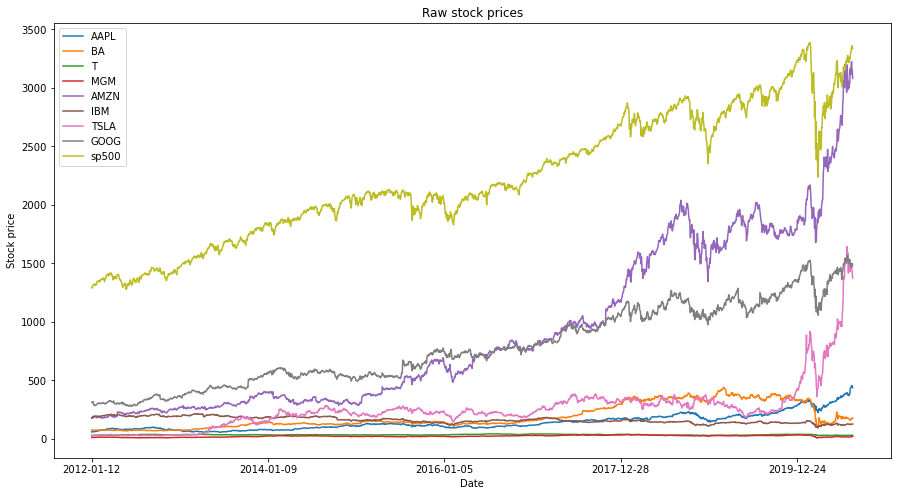

In [4]:
sprice_plotter(stocks, 'Raw stock prices')

The data does not present any null values and is all ordered by date. We can see that there is great variability in each company stock price largely due to shocks present in the large time window considered.

## Visualization and 1st step toward the CAPM

In [5]:
def heatmap(df, title):
    '''this function plots a correaltion heatmap.
    inputs: dataframe of returns, title of plot
    returns: nothing'''
    plt.figure(figsize=(8,8))
    #generate heatmap froom the correlation table
    sn.heatmap(df.corr(), annot=True)
    plt.title(title)
    plt.show()

In [6]:
def daily_returns(data):
    '''This function calculates daily stock returns for a passed dataframe
    
    input: dataframe
    returns: dataframe of daily returns'''
    
    #generating copy of passed dateframe (avoid inplace modification)
    data1 = data.copy()
    
    #looping
    for s in data.columns:
        if s!='Date':
            for i in range(len(data.loc[:, s])):
                if i ==0:
                    continue
                else:
                    data1.loc[i, s] = (data.loc[i, s]/data.loc[i-1, s])-1
    return data1[1:]

In [7]:
#Generating returns
returns = daily_returns(stocks)

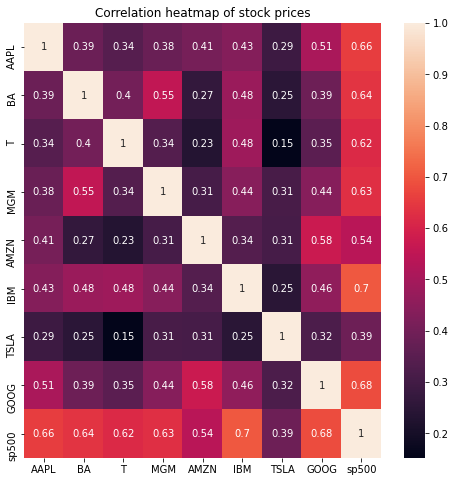

In [8]:
#Generating heatmap
heatmap(returns, 'Correlation heatmap of stock prices')

We first started by plotting heath map of correlations between all the stocks to get a sense of how correlated stocks where amongst themselves and with the market. Indeed we can see that most of the highest correlations are with the market (S&P 500), and this is likely because the S&P 500 already contains most of these companies. In addition however we see that the next highest correlations are between Amazon and Google and between Apple and Google. Indeed, this is to be expected as all these companies operate in the tech field and have moved towards providing services linked to the cloud, increasing the correlation amongst them.

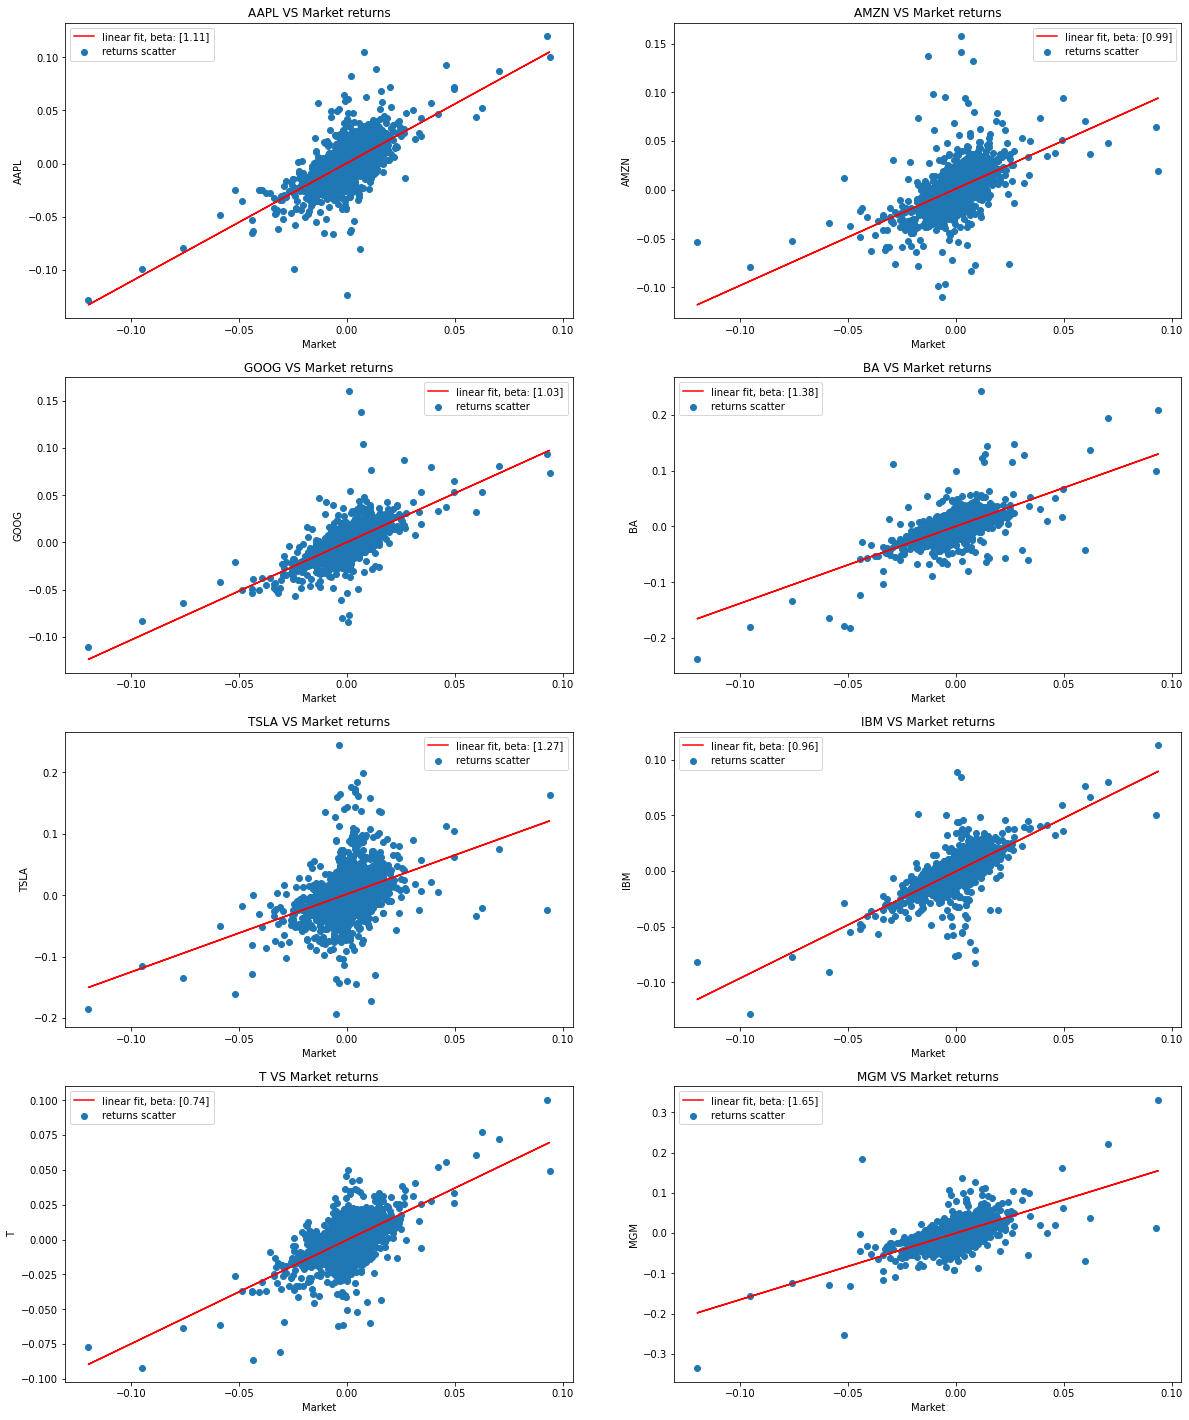

In [9]:
#Inspecting the correlation between the market and the different stocks considered

cols=returns.columns[1:-1].tolist() #selecting columns with stock information

fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(20,25))
for i in range(4):
    for j in range(2):
        ax=axs[i,j]
        selected=np.random.choice(cols, size=1)
        cols.remove(selected)
        ax.scatter(returns['sp500'], returns[selected], label ='returns scatter')
        coeff, inter  = np.polyfit(returns['sp500'], returns[selected], 1)
        ax.plot(returns['sp500'], coeff*returns['sp500']+inter, c = 'r', label =f'linear fit, beta: {np.round(coeff, 2)}')
        ax.set_ylabel(selected[0])
        ax.set_xlabel('Market')
        ax.set_title (f'{selected[0]} VS Market returns')
        ax.legend()
        
plt.show()

Consistent with our heathmap, as we can see from the plots there is a particularly strong correlation between the market (here sp500) and IBM,Google and Apple. This is expected as they are leaders in the tech market, a sector that has ample volatility and is therefore likely to explain also lots of the variation in the market itself. In addition, we see that overall most of the stocks present in our dataset have a pretty high and positive correlation with the market. 

This is expected since, as seen below if we calculate the fraction of stocks that are also present in the sp500 tickers (scraped form the internet) we indeed see that all the stocks in our dataset are contained in it.

In [10]:
#Requesting html of page
URL = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
page = requests.get(URL)

soup = BeautifulSoup(page.content, 'html.parser')

In [12]:
#Scraping the tickers
tables = soup.find_all("table")
table = tables[0]
tab_data = [[cell.text for cell in row.find_all(["th","td"])]
                        for row in table.find_all("tr")]
#Saving the tickers in a data frame
tickers = pd.DataFrame(tab_data)
tickers = tickers.iloc[:,:2]
#Cleaning text to remove unneded whitespaces
for i in range(tickers.shape[0]):
    tickers.iloc[i,0] = tickers.iloc[i,0].replace('\n','')
tickers.columns = tickers.iloc[0]
tickers.drop(tickers.index[0], inplace = True)
tickers.head()

,Symbol,Security
1,MMM,3M
2,AOS,A. O. Smith
3,ABT,Abbott
4,ABBV,AbbVie
5,ABMD,Abiomed


In [13]:
print(f"Fraction of stocks in our dataset that are in common with the sp500: {len(set(tickers['Symbol']).intersection(set(returns.columns)))/len(returns.columns[1:-1])}")

Fraction of stocks in our dataset that are in common with the sp500: 1.0


## Computing alpha and beta

In [14]:
#Generating temporary stores for the values extracted
sname = []
tval_inter = []
tval_coeff = []
intercept = []
coeff = []
cols=returns.columns[1:-1].tolist()#selecting columns with stock information

#Looping though the stocks to extract alphas and betas of each
for i in cols:
    sname.append(i)
    model = sm.ols(f'{i}~sp500', data = returns).fit() #fitting model
    tval_inter.append(model.tvalues[0]) #t-value alpha
    tval_coeff.append(model.tvalues[1]) #t-value beta
    intercept.append(model.params[0]) #alpha
    coeff.append(model.params[1]) #beta

#Saving in a data frame
parameters = pd.DataFrame({'stock_name':sname, 'intercept': intercept, 'intercept_tvalue': tval_inter, 
                           'coefficient': coeff, 'coefficeint_tval': tval_coeff})
parameters.head()

,stock_name,intercept,intercept_tvalue,coefficient,coefficeint_tval
0,AAPL,0.000528,1.831244,1.112891,40.499922
1,BA,-0.000023,-0.061338,1.382867,38.862544
2,T,-0.000286,-1.332180,0.744630,36.448649
3,MGM,-0.000169,-0.367897,1.653568,37.811805
4,AMZN,0.001023,2.922175,0.991732,29.756303


In [15]:
def parameter_plotter(df, x_column_name, column1, column2, title1, y_axis1, title2, significance=True):
    '''this function utlilises the passed data frame to generate barcharts of values of 
    different parameters across stocks returns
    
    inputs: dataframe of parameters, 
            name of column containing stock names, 
            values of parameter 1 
            values of parameter2
            title of plot 1
            y axis label
            title of plot 2
            whether want to display lines representing 95% significnace level 
    returns: nothing
    '''
    
    #generate plotting grid
    fig, axs =plt.subplots(ncols=2, figsize=(16,6))
    
    #plotting information in first barchart
    ax=axs[0]
    ax.bar(df[x_column_name], df[column1], color='blue')
    
    #option to add statistical significance lines
    if significance:
        ax.axhline(1.96, color="red")
        ax.text(1.02, 1.96, "95% t-value", va='center', ha="left", bbox=dict(facecolor="r",alpha=0.5),
                transform=ax.get_yaxis_transform())
        ax.axhline(-1.96, color="red")
        ax.text(1.02, -1.96, "95% t-value", va='center', ha="left", bbox=dict(facecolor="r",alpha=0.5),
                transform=ax.get_yaxis_transform())
    ax.set_title(title1)
    ax.set_xlabel('stock_name')
    ax.set_ylabel(y_axis1)

    #plotting infromation in second barchart
    ax=axs[1]
    ax.bar(df[x_column_name], df[column2], color='green')
    
    #option to add statistical significance lines
    if significance:
        ax.axhline(1.96, color="red")
        ax.text(1.02, 1.96, "95% t-value", va='center', ha="left", bbox=dict(facecolor="r",alpha=0.5),
                transform=ax.get_yaxis_transform())
        ax.axhline(-1.96, color="red")
        ax.text(1.02, -1.96, "95% t-value", va='center', ha="left", bbox=dict(facecolor="r",alpha=0.5),
                transform=ax.get_yaxis_transform())

    ax.set_title(title2)
    ax.set_xlabel('stock_name')
    ax.set_ylabel(y_axis1)
    plt.show()

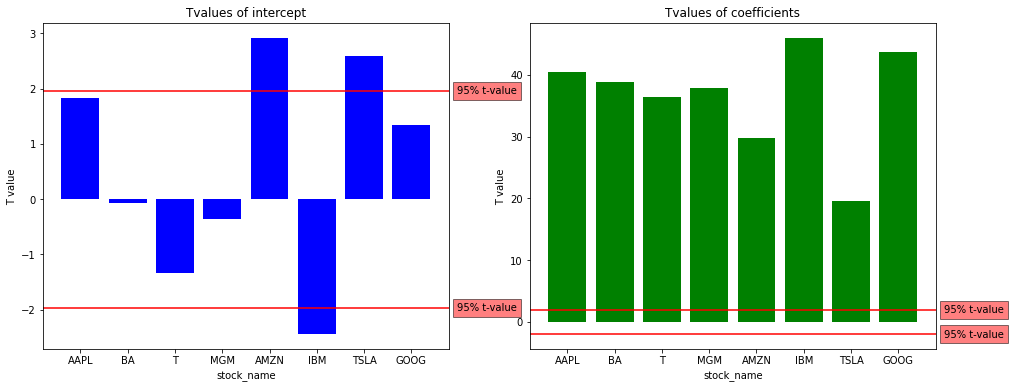

In [16]:
parameter_plotter(parameters, 'stock_name', 'intercept_tvalue','coefficeint_tval','Tvalues of intercept', 
                  'T value','Tvalues of coefficients', True  )

As we can see from the above bar charts, we identify that all Beta coeffients are statistically significant at the 5% confidence level. Also some of the alpha intercepts are significantly different from zero at the 5% confidence level. This diverges from the CAPM theory whereby all alphas should be statistically equal to zero. Such result suggest that arbitrage opportunities are present for AMZN, IBM and TSLA. In particular, according to the CAPM results by going long in AMZN and TSLA, shorting IBM, the market and investing in the risk free asset will lead to return without risk.

However, it is very likely that there are other risks not considered that affect the results, leading to the consideration that the identified arbitrage opportunities, in reality, might bear risk. More complex models, such as the APM should be implemented. 

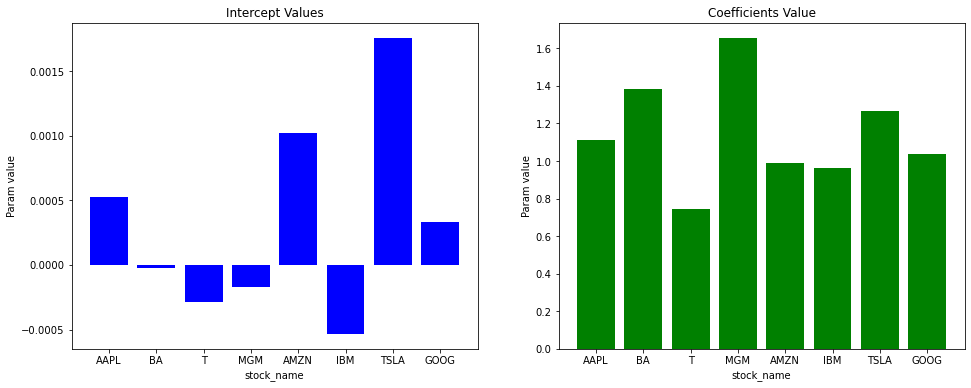

In [17]:
parameter_plotter(parameters, 'stock_name', 'intercept','coefficient','Intercept Values', 
                  'Param value','Coefficients Value', False  )

The companies with the highest alphas are TSLA and AMZN. This result is not surprising as those companies have grown tremendously during the time frame considered thanks to important technological improvements that have influenced those sectors.

Considering the Beta coefficients values, MGM and BA have the highest. Those high betas are likely due to the covid-19 pandemic which has significantly impacted the travel industry, of which those companies are a huge part of. Moreover, those companies may be affected by seasonality aspects, leading to high variability throughout each year.

### Analysis of error terms

In [18]:
def compute_errors(df):
    ''' This function takes utilises the passed dataframe of stocks realised returns to compute errors 
    with predicted returns from a CAPM model

    inputs: data frame of realised returns
    returns: data frame with errors
    '''
    errors = []
    for i in cols:
        sname.append(i)
        model = sm.ols(f'{i}~sp500', data = df).fit() #fitting model
        preds = model.predict(returns['sp500'])
        errors.append(np.array(returns[i])-np.array(preds)) #computing errors

    #generating data frame with dates
    df_errs=pd.DataFrame({'Date':returns['Date']})

    #adding the errors to the appropriate column
    for i in range(len(cols)):
        df_errs[cols[i]]=errors[i]
    return df_errs

In [19]:
#computing errors
df_errs = compute_errors(returns)
df_errs.head()

,Date,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG
1,2012-01-13,0.001229,-0.005186,0.002310,0.026488,0.018038,-0.002412,-0.188756,-0.002598
2,2012-01-17,0.007166,0.003689,0.003626,-0.013803,0.013613,0.001811,0.160912,0.001734
3,2012-01-18,-0.002506,-0.017730,-0.005341,0.020985,0.030789,-0.004189,-0.007956,-0.004941
4,2012-01-19,-0.009194,-0.000145,-0.000424,-0.002499,0.020526,-0.007246,-0.009889,0.005078
5,2012-01-20,-0.018690,-0.001432,0.002746,-0.013438,-0.019789,0.044208,-0.008588,-0.084802


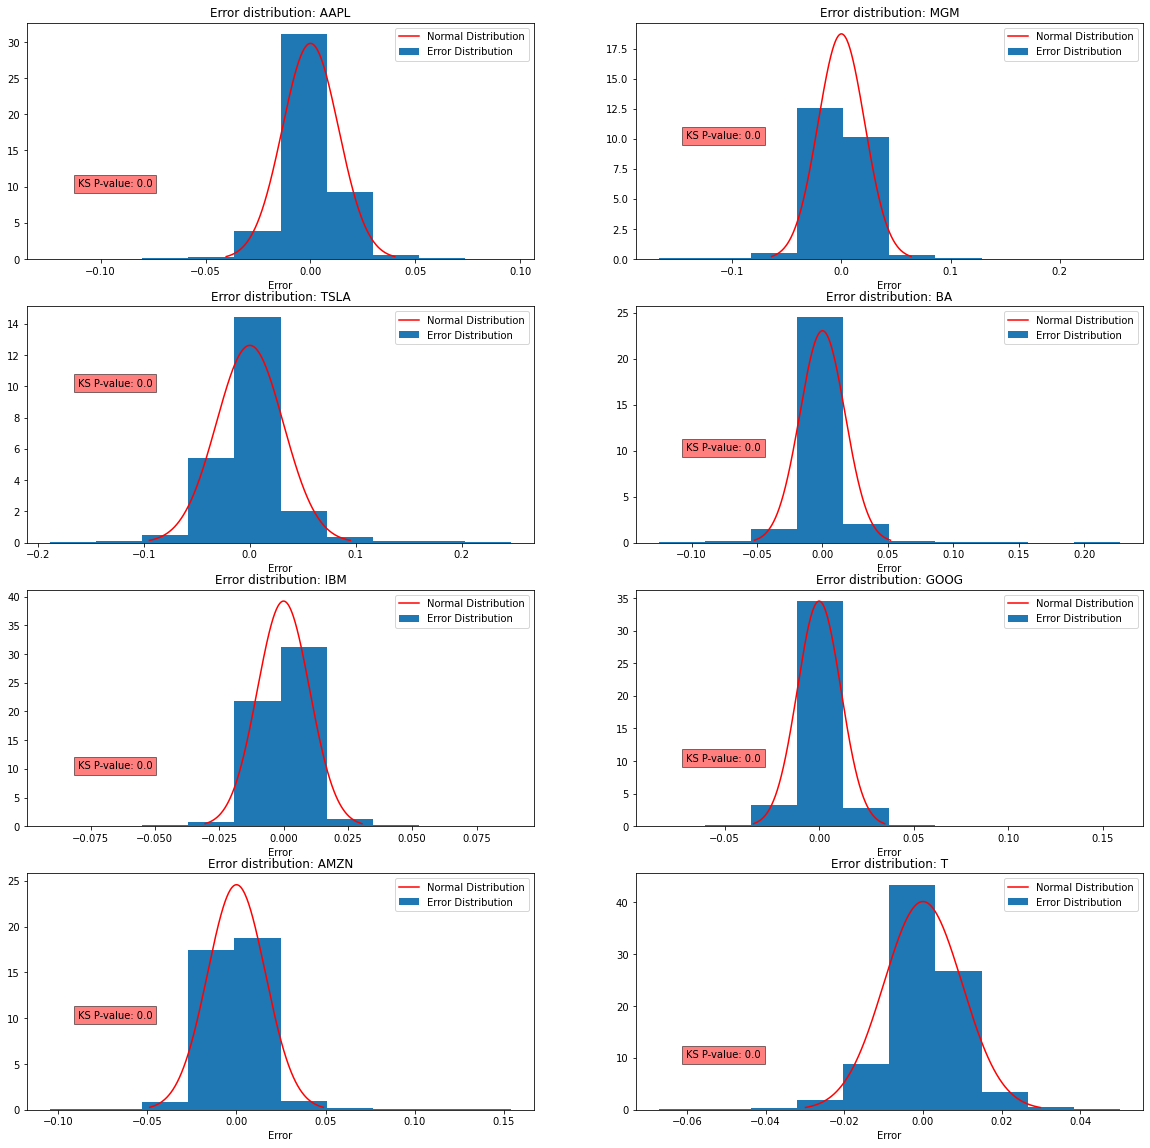

In [20]:
#Plotting histograms
cols=returns.columns[1:-1].tolist()
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(20,20))

for i in range(4):
    for j in range(2):
        ax=axs[i,j]
        selected=np.random.choice(cols, size=1)
        cols.remove(selected)
        
        #plotting histogram of errors
        ax.hist(df_errs[selected], density=True, label='Error Distribution')
        ax.set_xlabel('Error')
        ax.set_title(f'Error distribution: {selected[0]}')
        
        #generating and plotting normal distribution with mean zero and variance of error terms of the stock
        mu = 0
        std = np.std(df_errs[selected])
        x = np.linspace(mu - 3*std, mu + 3*std, len(df_errs[selected]))
        ax.plot(x, stats.norm.pdf(x, mu, std), color='red', label='Normal Distribution')
        
        #running KS test
        ks_t=kstest(df_errs[selected].to_numpy().ravel(), stats.norm.pdf(x, mu, std).ravel())[1]
        ax.text(0.1, 10, f'KS P-value: {ks_t}', bbox=dict(facecolor="r",alpha=0.5),
        transform=ax.get_yaxis_transform())
        ax.legend()
        
plt.show()

By comparing the error plots of the different stocks with the CAPM assumed normal distribution with mean 0 and standard deviation of the errors, it is possible to detect a rejection of one of the fundamental tenets of the CAPM theory, namely the symmetrical distribution of the error terms. Indeed, performing a Kolmogorov-Smirnov test highlights that all error distributions are significantly different from a normal distribution. Even graphically, it is possible to detect skeweness and kurtosis issues in all plots.

### Portfolio of risky assets

In [21]:
#Constructing the portfolio of the riskiest stocks
cols=returns.columns[1:-1].tolist()
predicted_ret = []

#Running model to generate predictions for each stock
for i in cols:
    sname.append(i)
    model = sm.ols(f'{i}~sp500', data = returns).fit()
    preds = model.predict(returns['sp500'])
    predicted_ret.append(preds)

# Saving them in a data frame with also the date
df_preds=pd.DataFrame({'Date':returns['Date']})
for i in range(len(cols)):
    df_preds[cols[i]]=predicted_ret[i]

#Sorting by beta values and selecting the top 4
risky_assets = list(parameters.sort_values(ascending = False, by = 'coefficient')['stock_name'][:4])
portfolio = df_preds.loc[:, risky_assets]
portfolio['Portfolio_returns'] = np.sum((portfolio.to_numpy()*0.25), axis = 1)
portfolio['realised_returns']= np.sum((returns.loc[:, risky_assets].to_numpy()*0.25), axis= 1)
portfolio.head()

,MGM,BA,TSLA,AAPL,Portfolio_returns,realised_returns
1,-0.008351,-0.006865,-0.004518,-0.004978,-0.006178,-0.047735
2,0.005706,0.004890,0.006266,0.004482,0.005336,0.044827
3,0.018199,0.015338,0.015851,0.012890,0.015569,0.013767
4,0.007997,0.006807,0.008024,0.006025,0.007213,0.001781
5,0.000938,0.000903,0.002608,0.001273,0.001431,-0.009106


In [22]:
#Generating data based on our predictions to plot cumulative performance changes of predicted vs realised
Predicted=[100]
Realized=[100]

for i in portfolio['Portfolio_returns'].tolist():
    Predicted.append(Predicted[-1]*(1+i))

for i in portfolio['realised_returns'].tolist():
    Realized.append(Realized[-1]*(1+i))

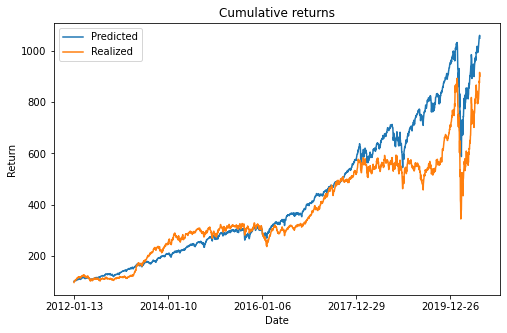

In [23]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(df_preds['Date'], Predicted[1:], label='Predicted')
ax.plot(df_preds['Date'],Realized[1:], label='Realized')
ax.set_title('Cumulative returns')
ax.set_xlabel('Date')
ax.set_ylabel('Return')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.legend()
plt.show()

By analyzing the cumulative returns predicted by the CAPM and the realized ones, it is possible to observe an overall good fit of the CAPM model. Importantly, it is worth noting that performance worsens after the beginning of 2018. A possible result for this is due to the fact that the CAPM is not updated frequently, thus not capturing the time varying nature of the beta coefficients. Potentially, models like the APM, by incorporating more risk components will more adequately capture the high variation of predictions and errors from 2018 onwards. Finally, such good fit is likely due to overfitting as the model has seen, during its training phase, all the data on which it is making predictions, making high accuracy very likely. 

Overall, statements of the predictive performance of the CAPM cannot be really drawn from this result. A more in depth study of this last part will be carried out later.

## Testing the CAPM theory

### 3.1 computing betas

In [24]:
#training and predicting with the CAPM
cols=returns.columns[1:-1].tolist()
full_preds = []
full_betas = []
for s in cols:
    stock_pred = []
    stock_beta = []
    for i in range(252, len(returns), 252):
        train = returns[i-252:i]
        test = returns[i:i+252]
        model = sm.ols(f"{s}~sp500", data = train).fit()
        preds = model.predict(test['sp500'])
        stock_pred.append((1+np.mean(preds))**252-1)
        stock_beta.append(model.params[1])
    full_preds.append(stock_pred)
    full_betas.append(stock_beta)

In [25]:
pred_annualized_rets = pd.DataFrame(np.array(full_preds), index = cols).T

pred_annualized_rets['Date'] =[2013,2014,2015,2016,2017,2018,2019,2020]
pred_annualized_rets

,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,Date
0,0.365041,0.147855,0.207694,0.366992,0.804766,0.174339,0.617096,0.284771,2013
1,0.090252,0.619656,-0.094486,0.622537,0.238994,-0.117579,4.005883,0.404543,2014
2,0.225339,-0.171601,-0.070681,-0.318892,-0.363948,-0.237442,0.041971,-0.235189,2015
3,0.233842,0.273981,0.230859,0.524478,1.800987,0.092156,0.527118,0.894585,2016
4,0.290682,0.319105,0.234042,0.560488,0.505181,0.341014,0.264458,0.201063,2017
5,0.048383,0.693361,-0.248872,-0.081955,0.151379,-0.152423,0.122925,0.021927,2018
6,0.329146,0.564913,0.034102,0.198514,1.219232,-0.013753,0.775282,0.485977,2019
7,0.700832,-0.171254,0.172702,0.058978,-0.064525,-0.010235,0.389634,0.162150,2020


In [26]:
#Computing the real returns
cols=returns.columns[1:-1].tolist()
ann_rets = []
for s in cols:
    annuals = []
    for i in range(252, len(returns), 252):
        year = returns[i:i+252][s]
        annuals.append((1+np.mean(year))**252-1)
    ann_rets.append(annuals)
annualized_rets = pd.DataFrame(np.array(ann_rets), index = cols).T
annualized_rets['Date'] =[2013,2014,2015,2016,2017,2018,2019,2020]
annualized_rets

,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,Date
0,0.193535,0.865709,0.012448,1.038566,0.508581,-0.007275,5.107664,0.621143,2013
1,0.374860,-0.056896,-0.005700,-0.174393,-0.235226,-0.164171,0.298238,-0.105493,2014
2,-0.057241,-0.009492,0.035450,0.061017,1.106797,-0.139553,0.153327,0.448972,2015
3,0.266473,0.289173,0.222983,0.511996,0.476702,0.316062,0.235858,0.179985,2016
4,0.516026,1.265846,-0.089665,0.315839,0.633359,0.017674,0.569132,0.423857,2017
5,-0.087361,0.075121,-0.143762,-0.187307,0.398296,-0.252581,0.187989,0.003556,2018
6,1.103612,-0.060882,0.272356,0.286356,0.127621,0.154892,0.661493,0.395722,2019
7,1.013398,-0.363326,-0.278362,-0.105377,1.658270,-0.030374,8.250142,0.104471,2020


### 3.2 comparing realized vs predicted

In [27]:
#merging real data and predicted one
plot_df=pd.merge(pred_annualized_rets, annualized_rets, on ='Date', suffixes=('_preds', ''))

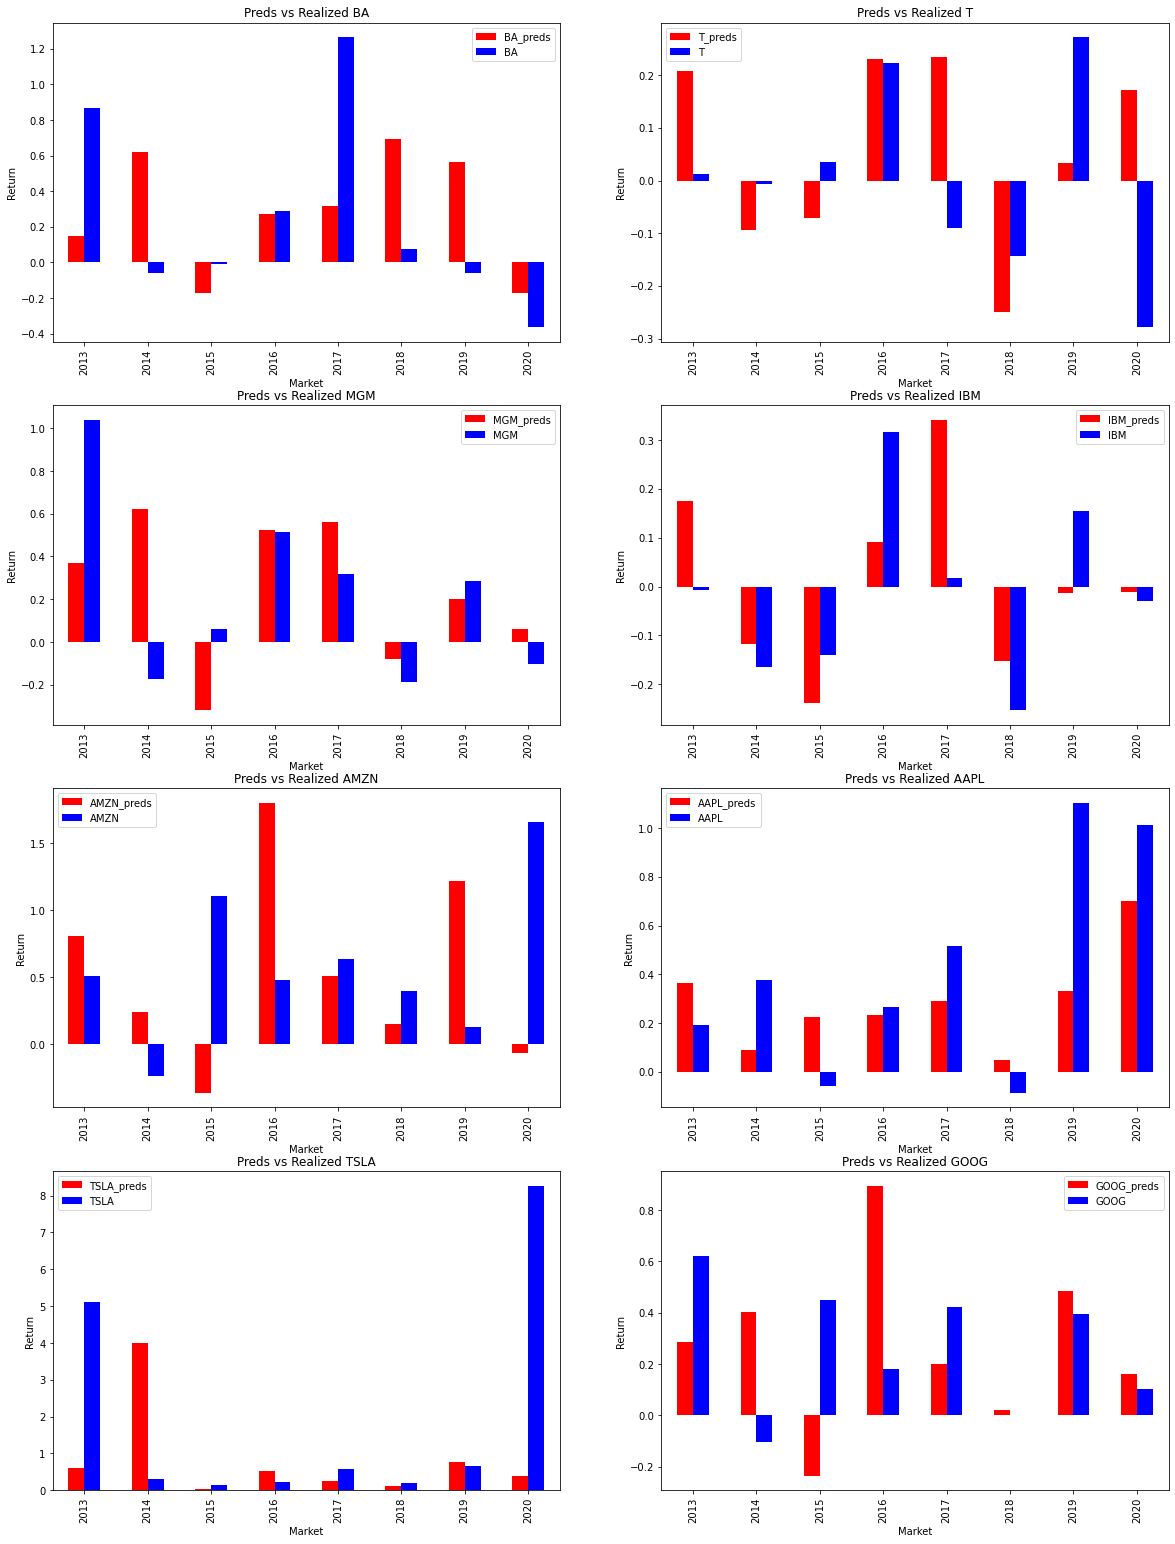

In [28]:
cols=returns.columns[1:-1].tolist()
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(20,27))
for i in range(4):
    for j in range(2):
        ax=axs[i,j]
        selected=np.random.choice(cols, size=1)[0]
        cols.remove(selected)
        rem_p=selected+'_preds'
        plot_df.plot.bar(x = 'Date', y = [rem_p, selected], ax=ax,  color=['red', 'blue'])
        ax.set_ylabel('Return')
        ax.set_xlabel('Market')
        ax.set_title(f'Preds vs Realized {selected}')
        ax.legend()
        
plt.show()

Overall, the predictive performance of the CAPM on a yearly predictive basis is quite poor. This is likely due to the fact that by predicting and updating for long periods, the granularity in betas will not be captured. By analylizing the above graphs in more depth, part of the poor predictive power is due to the unforeseeable Covid-19 pandemic. Indeed, the highest divergence between predicted and actual values is located between of 2019 and 2020. The remaining lack in predictive power can be explained by the absence of other measures of risk as only market risk is considered. Moreover, since the selected stocks are part of the tech sector and the travel/entertainment industry, which, as identified by Kogan and Wang (2021), showcase high risk, high volatility in returns is expected. Once again, with more frequent updating of betas, performance could be improved.

Part of the poor predictive performance is also due to the poor relationship between betas and returns (shown below).

### 3.3 Scatters of beta vs realised returns

In [29]:
cols=returns.columns[1:-1].tolist()
betas = pd.DataFrame(np.array(full_betas), index = cols).T
betas['Date'] =[2013,2014,2015,2016,2017,2018,2019,2020]
merged_betas=pd.merge(betas, annualized_rets, on ='Date', suffixes=('_betas', ''))
merged_betas

,AAPL_betas,BA_betas,T_betas,MGM_betas,AMZN_betas,IBM_betas,TSLA_betas,GOOG_betas,Date,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG
0,1.273006,1.029482,0.654639,1.726291,1.099353,0.857770,1.607605,0.866507,2013,0.193535,0.865709,0.012448,1.038566,0.508581,-0.007275,5.107664,0.621143
1,0.597562,0.935273,0.736436,1.509748,1.300678,0.777011,1.321604,0.947917,2014,0.374860,-0.056896,-0.005700,-0.174393,-0.235226,-0.164171,0.298238,-0.105493
2,0.905098,1.017902,0.530682,1.509202,1.445261,0.719845,1.727884,1.229208,2015,-0.057241,-0.009492,0.035450,0.061017,1.106797,-0.139553,0.153327,0.448972
3,1.120896,1.048607,0.720279,1.510736,1.190231,0.992919,1.170403,1.118915,2016,0.266473,0.289173,0.222983,0.511996,0.476702,0.316062,0.235858,0.179985
4,0.982216,1.190696,0.466890,1.638685,0.991456,0.974419,1.186641,0.918161,2017,0.516026,1.265846,-0.089665,0.315839,0.633359,0.017674,0.569132,0.423857
5,1.420005,1.123176,0.738849,1.385143,1.346671,0.703265,1.288383,1.276704,2018,-0.087361,0.075121,-0.143762,-0.187307,0.398296,-0.252581,0.187989,0.003556
6,1.312675,1.311593,0.658597,1.355843,1.615809,0.967201,1.404110,1.371096,2019,1.103612,-0.060882,0.272356,0.286356,0.127621,0.154892,0.661493,0.395722
7,1.486037,0.871532,0.569265,1.357374,1.302992,1.076366,1.248194,1.278476,2020,1.013398,-0.363326,-0.278362,-0.105377,1.658270,-0.030374,8.250142,0.104471


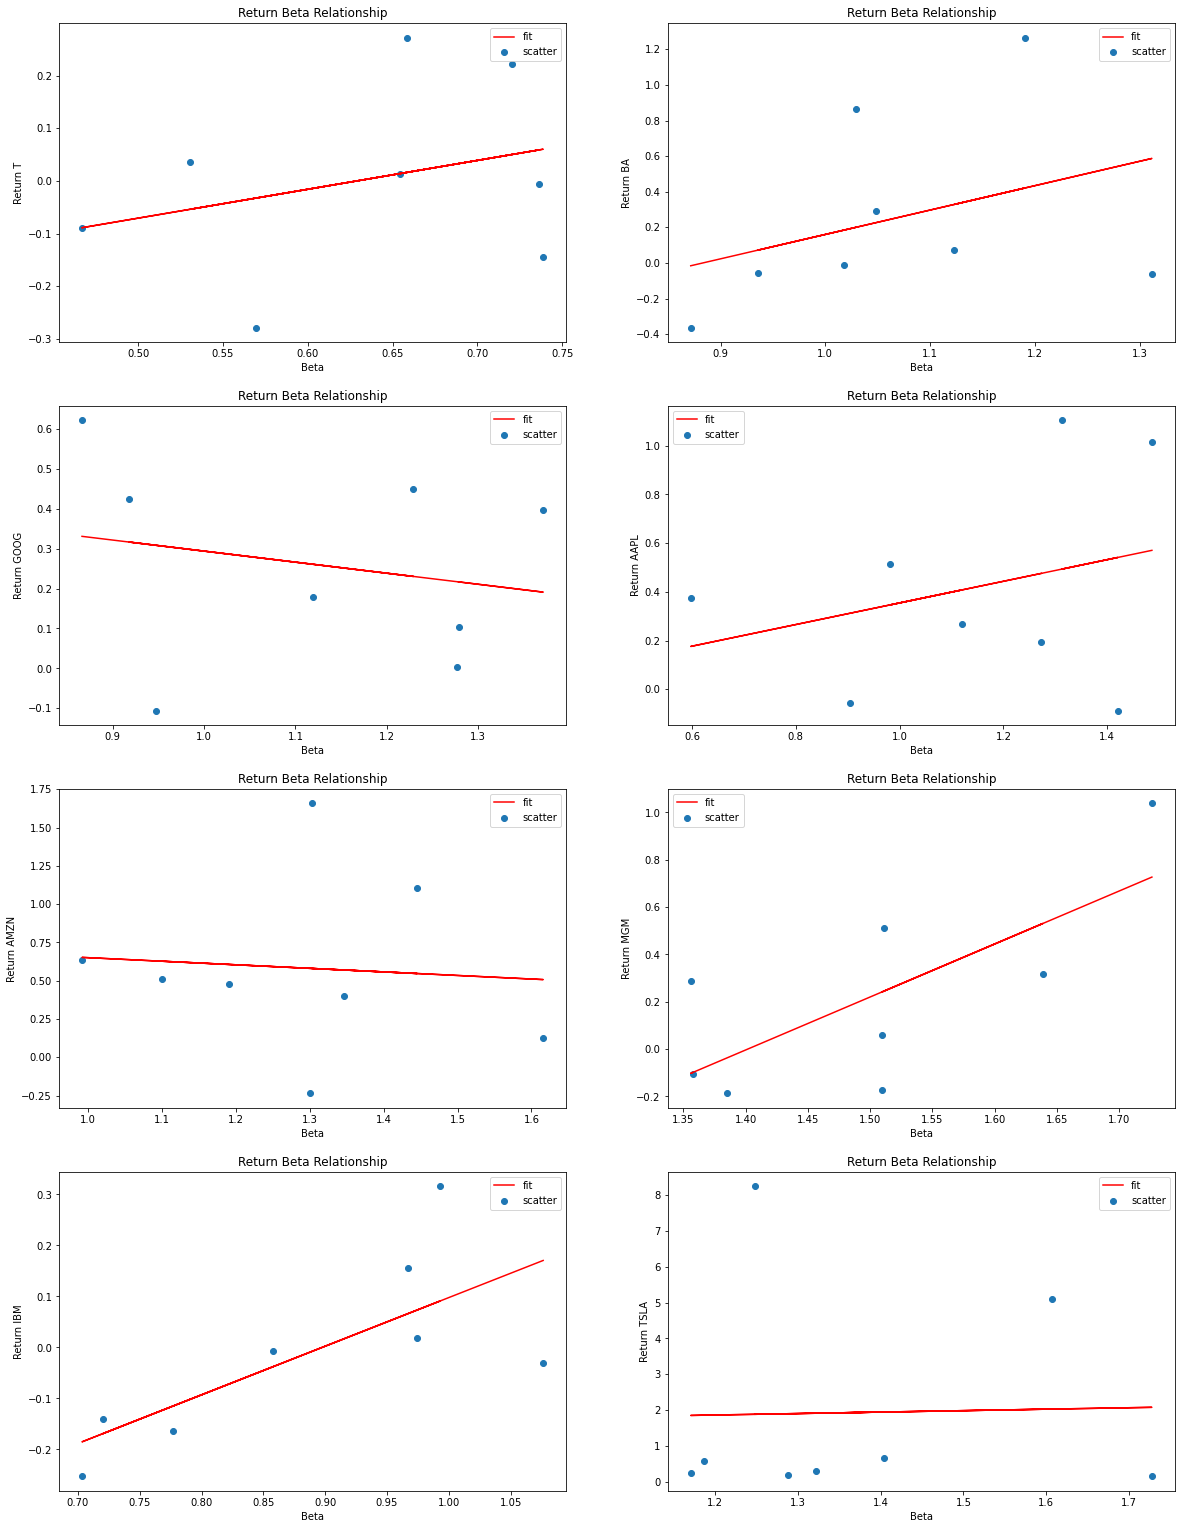

In [30]:
cols=returns.columns[1:-1].tolist()
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(20,27))
for i in range(4):
    for j in range(2):
        ax=axs[i,j]
        selected=np.random.choice(cols, size=1)[0]
        cols.remove(selected)
        rem_p=selected+'_betas'
        ax.scatter(merged_betas[rem_p], merged_betas[selected], label='scatter')
        coeff, intercept = np.polyfit(merged_betas[rem_p], merged_betas[selected], 1)
        #print(coeff, intercept)
        ax.plot(merged_betas[rem_p], coeff*merged_betas[rem_p]+intercept, color='red', label='fit')
        
        ax.set_ylabel(f'Return {selected}')
        ax.set_xlabel('Beta')
        ax.set_title(f'Return Beta Relationship')
        ax.legend()
        
plt.show()

### 3.4 Testing different time windows

In [31]:
## Testing with Different Time windows
def beta_tuner(returns, days, time_to_predict):
    cols=returns.columns[1:-1].tolist()
    full_preds = []
    full_betas = []
    
    for s in cols:
        stock_pred = []
        stock_beta = []
        for i in range(days, len(returns), time_to_predict):
            #we are sliding the range by the time_to_predict to ensure that every model 
            #will predict on the same n. of periods
            #a model with a 252 days window of training, at each step, will forgo the 
            #oldest month and update the dataset with
            #the newest month available. This reasoning applies for all time windows
            
            train = returns[i-days:i]
            test = returns[i:i+time_to_predict]
            model = sm.ols(f"{s}~sp500", data = train).fit()
            preds = model.predict(test['sp500'])
            stock_pred.append((1+np.mean(preds))**time_to_predict-1)
            stock_beta.append(model.params[1])
        full_preds.append(stock_pred)
        full_betas.append(stock_beta)
        
    cols=returns.columns[1:-1].tolist()
    betas = pd.DataFrame(np.array(full_betas), index = cols).T
    pred_annualized_rets = pd.DataFrame(np.array(full_preds), index = cols).T
    cols=returns.columns[1:-1].tolist()
    ann_rets = []
    
    for s in cols:
        annuals = []
        for i in range(days, len(returns), time_to_predict):
            year = returns[i:i+days][s]
            annuals.append((1+np.mean(year))**time_to_predict-1)
        ann_rets.append(annuals)
    annualized_rets = pd.DataFrame(np.array(ann_rets), index = cols).T
    
    mse = []
    for i in cols:
        mse.append(mean_squared_error(annualized_rets.loc[:, i], pred_annualized_rets.loc[:, i]))
    
    avg_mse = mean_squared_error(annualized_rets, pred_annualized_rets)
    return mse, betas, avg_mse, annualized_rets

Beta tuner logic:

We provide different time frames ranging from 1 business month up to 4 business years. For each time frame provided, we look at the predictive performance of the CAPM model on the next month of data available. After the prediction has been carried out we look at the MSE over the predicted month and we store it away in a list. Next, we update the training data to be used by including the latest business month of data available and we drop the oldest (i.e. more in the past) business month of observations. We repeat this procedure for the entire time span of the data.

We then identify the optimal time frame for training the data.

*Note: due to time constraints, we decided to make predictions in step of 1 business month. Ideally, this parameter should also be optimized.*

In [32]:
#Saving results in temporary lists
mse_l = []
betas_l=[]
avg_mse_l=[]
annualized_rets_l=[]
time_range=np.arange(21, 1008, 21) #due to time constraints we decided to analyze updating based on 1 business month

for i in tqdm(time_range):
    mse, betas, avg_mse, annualized_rets= beta_tuner(returns, i, min(time_range))
    mse_l.append(mse)
    betas_l.append(betas)
    avg_mse_l.append(avg_mse)
    annualized_rets_l.append(annualized_rets)

100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [06:10<00:00,  7.89s/it]


In [33]:
#Saving MSE results in a data frame for easier manipulation
cols=returns.columns[1:-1].tolist()
mse_stocks = pd.DataFrame(np.array(mse_l), columns=cols)
mse_stocks.head()

,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG
0,0.008396,0.024204,0.004438,0.034537,0.013733,0.005264,0.088822,0.005504
1,0.005619,0.006993,0.002575,0.017177,0.006111,0.002440,0.030748,0.003654
2,0.005175,0.005510,0.001781,0.011845,0.004134,0.001869,0.019465,0.003316
3,0.004811,0.004115,0.001491,0.008283,0.003846,0.001758,0.017954,0.003124
4,0.004490,0.003586,0.001370,0.008061,0.004198,0.001818,0.015102,0.003094


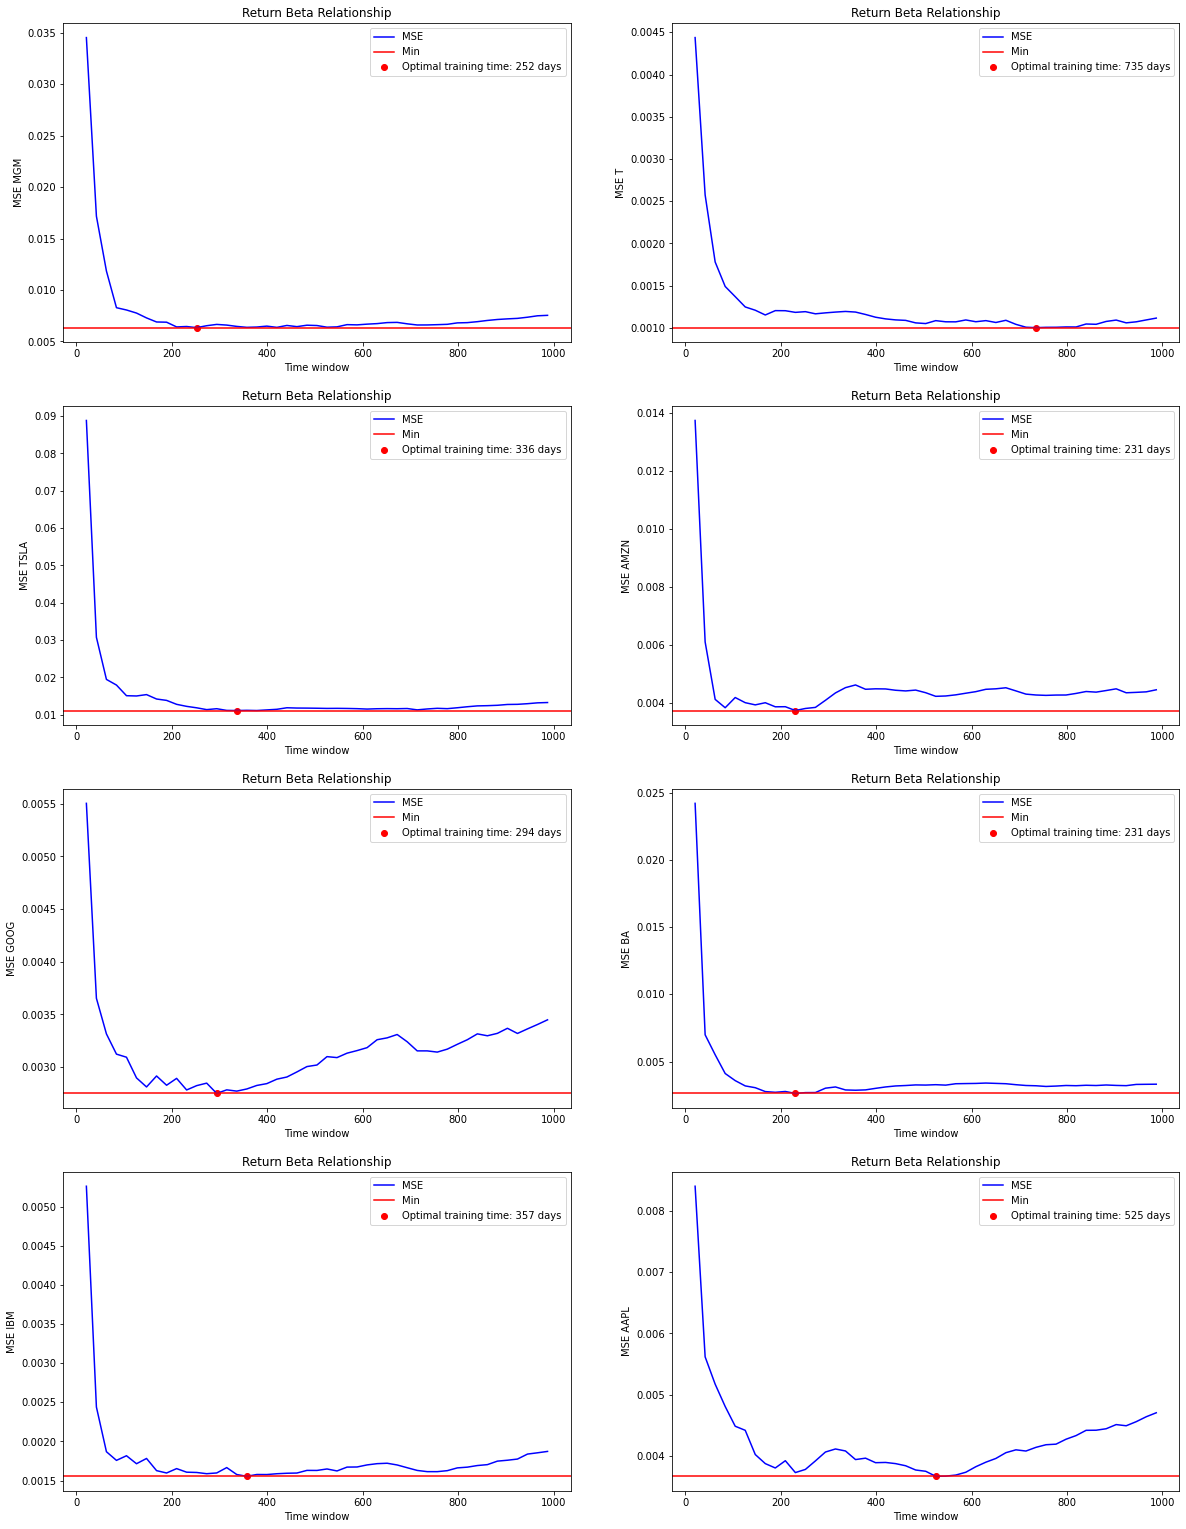

In [34]:
#Visualising the results
cols=returns.columns[1:-1].tolist()
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(20,27))
for i in range(4):
    for j in range(2):
        ax=axs[i,j]
        selected=np.random.choice(cols, size=1)[0]
        cols.remove(selected)
        
        #plotting MSE cruve
        ax.plot(time_range, mse_stocks[selected], color='blue', label=f'MSE')
        min_index = np.argmin(mse_stocks[selected])
        
        #adding minimum of MSE (i.e. optimal training time) 
        ax.scatter(time_range[min_index], mse_stocks[selected][min_index], color='red', label=f'Optimal training time: {time_range[min_index]} days')
        
        #Adding line of minimum MSE to better highlight variations from it
        ax.axhline(mse_stocks[selected][min_index],color='red', label='Min')
        ax.set_ylabel(f'MSE {selected}')
        ax.set_xlabel('Time window')
        ax.set_title(f'Return Beta Relationship')
        ax.legend()
        
plt.show()

From the above graphs, it is possible to detect that the optimal time window for training for all the stocks is around 1/1.5 business year. The only company for which this result does not apply is AT&T (ticker symbol T) for which the optimal training window is of around 2 business years. 

Given that Betas are time varying, using solely the most recent data to generate estimates (e.x. considering only 1/2/3 months for parameter estimation) might lead to overfitting and poor performance due to high predictive variance. Updating estimates over a larger time frame instead, seems to lead to more accurate results, as seen from the graphs above.

It is important to note that compared to exercise 2 of task 3 we decided to test the performance of the model on only 1 month following the training time. This is because testing effectiveness by predicting an entire year following training would result in trying to predict returns that are too far in to the future. The model would then not be exposed to shocks that happened during the testing year, leading to drops in performance. 

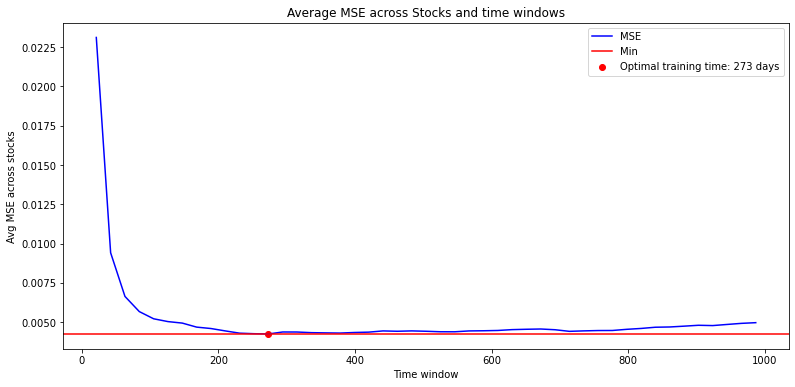

In [35]:
#Plotting the average
fig, ax = plt.subplots(figsize=(13,6))

ax.plot(time_range, avg_mse_l, color='b', label='MSE')
min_index = np.argmin(avg_mse_l)
ax.scatter(time_range[min_index], avg_mse_l[min_index], color='red', label=f'Optimal training time: {time_range[min_index]} days')
ax.axhline( avg_mse_l[min_index],color='red', label='Min')
ax.set_ylabel('Avg MSE across stocks')
ax.set_xlabel('Time window')
ax.set_title('Average MSE across Stocks and time windows')
ax.legend()
plt.show()

By considering the avg MSE, support is provided for the optimal time window of around 1 business year.

We will now better investigate the relationship between beta and returns.

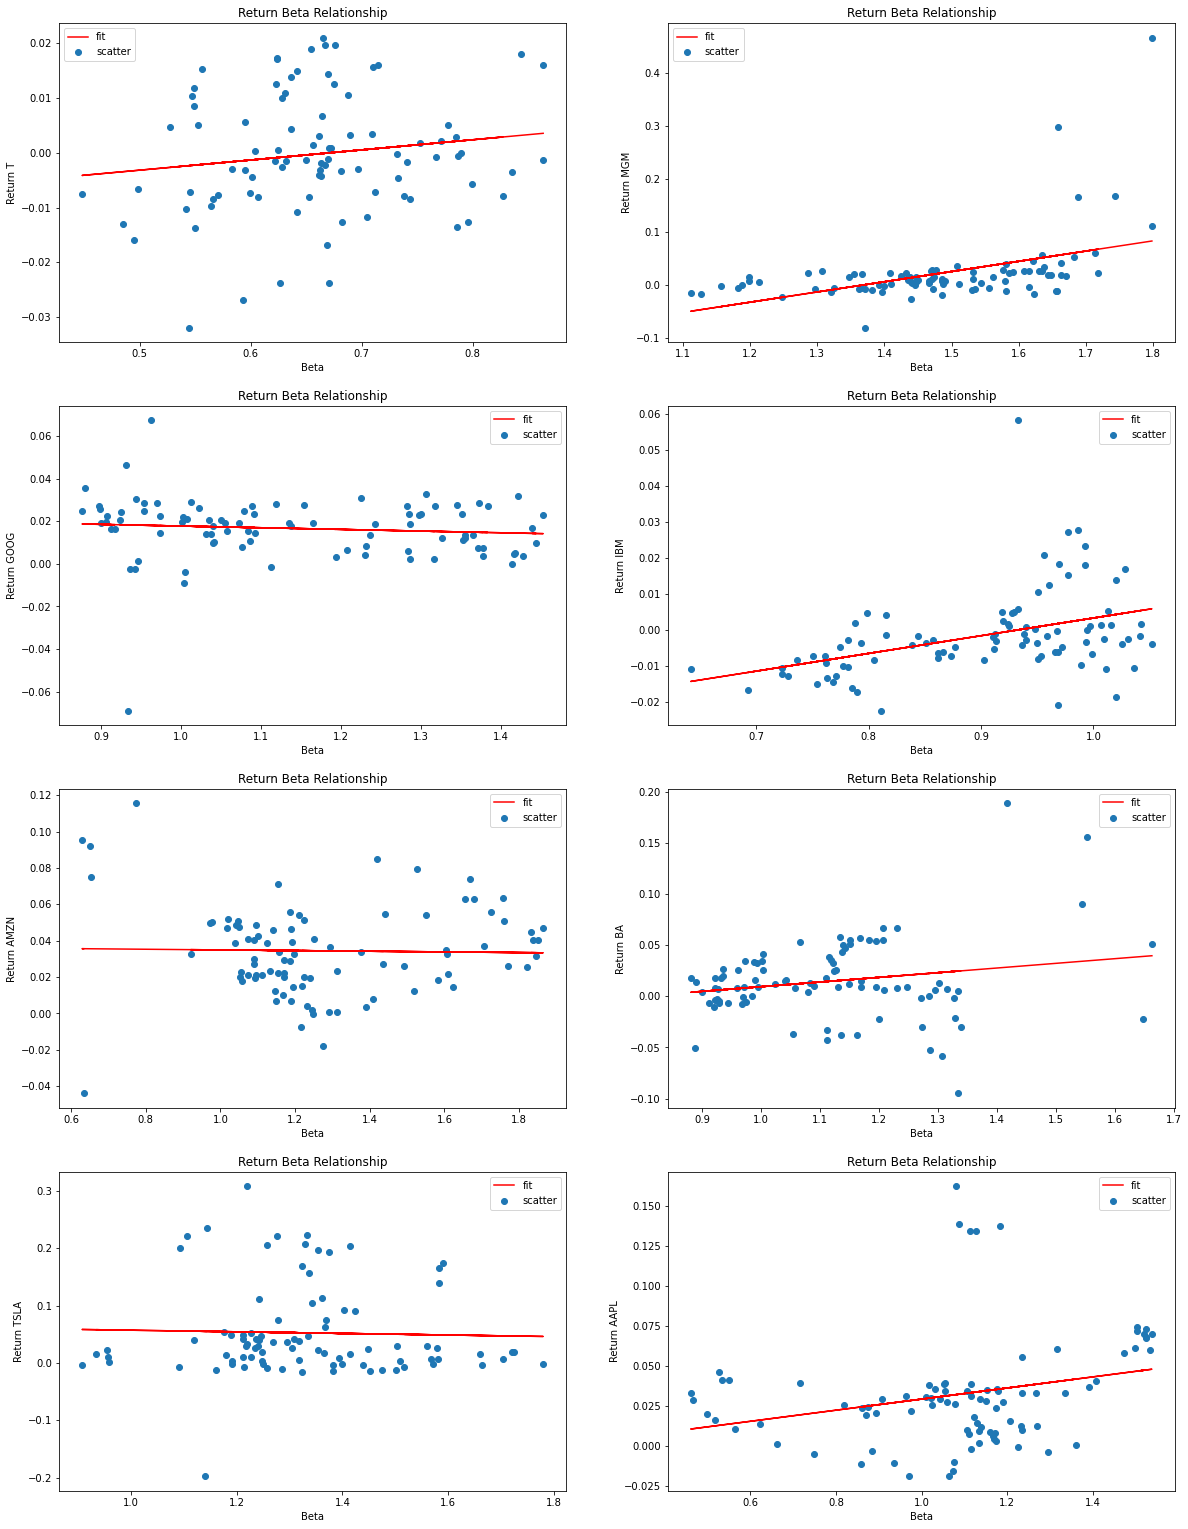

In [36]:
min_index = np.argmin(avg_mse_l)
optimal_bts=betas_l[min_index].reset_index()
annualized_rets=annualized_rets_l[min_index].reset_index()
df_beta_ret=pd.merge(optimal_bts, annualized_rets, on='index', suffixes=('_betas','')).drop('index', axis=1)

cols=returns.columns[1:-1].tolist()
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(20,27))
for i in range(4):
    for j in range(2):
        ax=axs[i,j]
        selected=np.random.choice(cols, size=1)[0]
        cols.remove(selected)
        rem_p=selected+'_betas'
        ax.scatter(df_beta_ret[rem_p], df_beta_ret[selected], label='scatter')
        coeff, intercept = np.polyfit(df_beta_ret[rem_p], df_beta_ret[selected], 1)
        ax.plot(df_beta_ret[rem_p], coeff*df_beta_ret[rem_p]+intercept, color='red', label='fit')
        
        ax.set_ylabel(f'Return {selected}')
        ax.set_xlabel('Beta')
        ax.set_title(f'Return Beta Relationship')
        ax.legend()
        
plt.show()

Despite the good fit on test data observed before, the expected beta-return relationship proposed by the CAPM model is instead not observed. More precisely, only a very small coefficient for the linear fit between the Beta return scatter is present. This result contrasts the theory. We hypothesize that this might be due to the fact that the CAPM model is too simplistic, thus not capturing other risks affecting the return. Ultimately, we believe that alphas across the various OLS estimations will be different from zero.

In conclusion, while it is possible to predict returns utilising the model proposed by the CAPM and reach a relatively contained error (provided the right training time is used and a limited time-horizon is predicted), the theoretical relationship between stock returns and market returns it establishes does not hold in practice.

## Obtain data from the web

We have already scraped the date as seen from the first task so here we are saving it in a new data frame to aid our commenting

In [38]:
final_tickers = list(set(tickers.Symbol).intersection(set(stocks.head().columns[1:])))
scraped_data = yp.download(final_tickers, start = stocks['Date'][0], end = stocks['Date'].iloc[-1])
scraped_data.head()

[*********************100%***********************]  8 of 8 completed


Adj Close                                                       \
                 AAPL    AMZN         BA       GOOG         IBM        MGM   
Date                                                                         
2012-01-11  12.885238  8.9450  61.156597  15.590563  117.385132  11.297279   
2012-01-12  12.849865  8.7965  61.786648  15.682219  116.245560  11.457857   
2012-01-13  12.801685  8.9210  61.042030  15.566403  115.350586  11.665667   
2012-01-17  12.950798  9.0830  61.565697  15.655818  115.891396  11.571208   
2012-01-18  13.085281  9.4720  61.418415  15.763664  116.580338  12.024608   

                                     Close          ...       Open            \
                    T      TSLA       AAPL    AMZN  ...          T      TSLA   
Date                                                ...                        
2012-01-11  10.318426  1.882000  15.091071  8.9450  ...  22.454683  1.841333   
2012-01-12  10.363158  1.883333  15.049643  8.7965  ...  22.719032  1.898667   
2012-01-13  10.345952  1.519333  14.993214  8.9210  ...  22.696375  1.893333   
2012-01-17  10.407888  1.773333  15.167857  9.0830  ...  22.885197  1.774667   
2012-01-18  10.435408  1.787333  15.325357  9.4720  ...  22.900303  1.779333   

               Volume                                                    \
                 AAPL       AMZN       BA       GOOG      IBM       MGM   
Date                                                                      
2012-01-11  215084800   62054000  3082700   96359832  4299897  21412700   
2012-01-12  212587200  107716000  3934500   75289148  7197526  17891100   
2012-01-13  226021600   95070000  4641100   92637933  5522043  16621800   
2012-01-17  242897200  112890000  3700100   76658261  6279556  15480800   
2012-01-18  276791200  149470000  4189500  110882061  4812228  18387600   

                                
                   T      TSLA  
Date                            
2012-01-11  31379594  10084500  
2012-01-12  35100696  10939500  
2012-01-13  29256163  82506000  
2012-01-17  31114265  69774000  
2012-01-18  29147860  18903000  

[5 rows x 48 columns]

The presented dataset contains some additional variables, not included in the previous,cleaned one. 
In particular, the mentioned dataset presents the values that get registered during a normal business day where exchanges of stocks take place. Indeed, stocks'prices keep fluctuating while the market is open as an effect of the several agreements reached during the day between the sellers and the buyers. 
To sum up the activities of the day, at the end of the business day,some informations are stored. These are the price of the stock at the start of the day (Open), the one at the end (Close), the amount of stock exchanged during the day(Volume) and the adjusted close price (Adj Close) which is just the cash value of the last transacted price before the market closes.